## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load datasets
owned_games = pd.read_csv('../data/owned_games_enriched.csv')
steam_catalog = pd.read_csv('../data/steam_catalog_detailed.csv')

print(f"Owned games: {len(owned_games)} games")
print(f"Steam catalog: {len(steam_catalog)} games")
print(f"\nOwned games columns: {list(owned_games.columns)}")

Owned games: 67 games
Steam catalog: 86542 games

Owned games columns: ['appid', 'name', 'playtime_forever', 'img_icon_url', 'playtime_windows_forever', 'playtime_mac_forever', 'playtime_linux_forever', 'playtime_deck_forever', 'rtime_last_played', 'content_descriptorids', 'playtime_disconnected', 'has_community_visible_stats', 'playtime_2weeks', 'has_leaderboards', 'playtime_hours', 'developer', 'publisher', 'score_rank', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'positive', 'negative', 'userscore', 'ccu', 'price', 'initialprice', 'discount', 'tags', 'languages', 'genre']


## 1. Create Engagement Score (Target Variable)

The engagement score combines:
- Playtime (normalized)
- Recency of play
- Whether game has achievements/stats

Engagement Score Statistics:
count    67.000000
mean     61.034002
std      24.927157
min       0.000000
25%      55.127533
50%      66.747135
75%      77.806766
max      99.983783
Name: engagement_score, dtype: float64


C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\3358854333.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['achievement_score'] = df['has_community_visible_stats'].fillna(False).astype(int) * 10


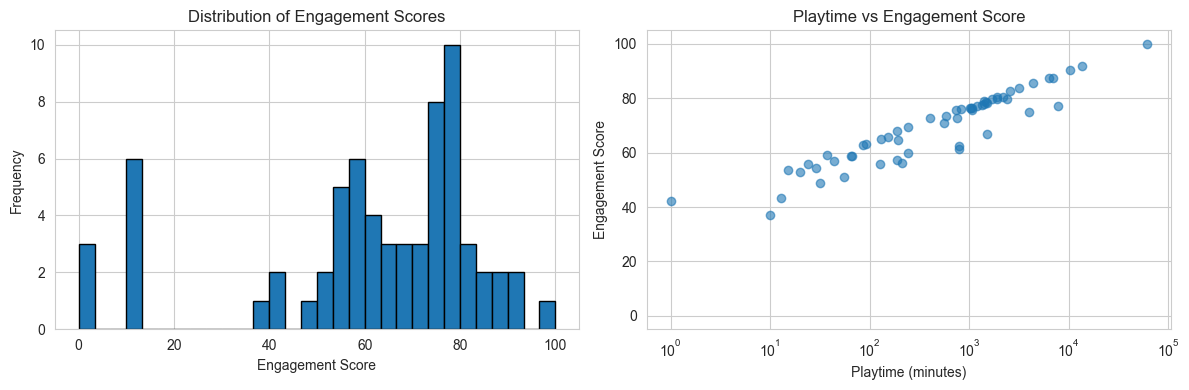

In [3]:
def create_engagement_score(df):
    """
    Create engagement score from playtime and other features
    Score ranges from 0-100
    """
    df = df.copy()
    
    # Playtime component (0-60 points)
    # Use log transform to handle skewed distribution
    df['playtime_score'] = np.log1p(df['playtime_forever'])
    df['playtime_score'] = (df['playtime_score'] / df['playtime_score'].max()) * 60
    
    # Recency component (0-30 points)
    # More recent play = higher score
    if 'rtime_last_played' in df.columns and df['rtime_last_played'].notna().any():
        max_time = df['rtime_last_played'].max()
        df['recency_score'] = df['rtime_last_played'].fillna(0)
        df['recency_score'] = (df['recency_score'] / max_time) * 30
    else:
        df['recency_score'] = 0
    
    # Achievement engagement (0-10 points)
    df['achievement_score'] = df['has_community_visible_stats'].fillna(False).astype(int) * 10
    
    # Combine scores
    df['engagement_score'] = (
        df['playtime_score'] + 
        df['recency_score'] + 
        df['achievement_score']
    )
    
    return df

owned_games = create_engagement_score(owned_games)

# Display engagement score distribution
print("Engagement Score Statistics:")
print(owned_games['engagement_score'].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(owned_games['engagement_score'], bins=30, edgecolor='black')
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Scores')

plt.subplot(1, 2, 2)
plt.scatter(owned_games['playtime_forever'], owned_games['engagement_score'], alpha=0.6)
plt.xlabel('Playtime (minutes)')
plt.ylabel('Engagement Score')
plt.title('Playtime vs Engagement Score')
plt.xscale('log')
plt.tight_layout()
plt.show()

## 2. Extract Tag Features from Owned Games

Parse the tag dictionaries and create a feature matrix where:
- Rows = games
- Columns = tags
- Values = tag vote counts

In [4]:
def parse_tags(tag_string):
    """
    Parse tag string into dictionary
    Handles both string and NaN values
    """
    if pd.isna(tag_string):
        return {}
    try:
        return ast.literal_eval(str(tag_string))
    except:
        return {}

# Parse tags for owned games
owned_games['tags_dict'] = owned_games['tags'].apply(parse_tags)

# Get all unique tags from owned games
all_tags = set()
for tags_dict in owned_games['tags_dict']:
    all_tags.update(tags_dict.keys())

print(f"Total unique tags in owned games: {len(all_tags)}")
print(f"\nSample tags: {list(all_tags)[:10]}")

Total unique tags in owned games: 193

Sample tags: ['First-Person', 'Mature', 'Extraction Shooter', 'Choices Matter', 'Surreal', 'Co-op', 'Free to Play', 'Loot', 'Sailing', '1980s']


In [5]:
# Create tag feature matrix
def create_tag_features(df, all_tags):
    """
    Create a feature matrix where each column is a tag
    and values are the vote counts (or 0 if tag not present)
    """
    tag_features = pd.DataFrame(index=df.index)
    
    for tag in sorted(all_tags):
        # Clean tag name for column (remove special chars)
        col_name = f"tag_{tag.replace(' ', '_').replace('-', '_').replace('&', 'and')}"
        tag_features[col_name] = df['tags_dict'].apply(
            lambda x: x.get(tag, 0) if isinstance(x, dict) else 0
        )
    
    return tag_features

tag_features = create_tag_features(owned_games, all_tags)
print(f"Tag feature matrix shape: {tag_features.shape}")
print(f"\nFirst few tag columns:\n{tag_features.iloc[:5, :5]}")

Tag feature matrix shape: (67, 193)

First few tag columns:
   tag_1980s  tag_1990's  tag_2D  tag_2D_Platformer  tag_3D
0          0        1984       0                  0       0
1          0           0       0                  0       0
2          0           0       0                  0       0
3          0           0       0                  0       0
4          0           0       0                  0       0


C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

## 3. Create Interaction Features

Weight tag votes by playtime to capture which tags the user actually engages with

In [6]:
# Create playtime weight (normalized)
owned_games['playtime_weight'] = np.log1p(owned_games['playtime_forever'])
owned_games['playtime_weight'] = owned_games['playtime_weight'] / owned_games['playtime_weight'].max()

# Create interaction features (tag_votes * playtime_weight)
interaction_features = tag_features.multiply(owned_games['playtime_weight'], axis=0)
interaction_features.columns = [col.replace('tag_', 'interaction_') for col in interaction_features.columns]

print(f"Interaction feature matrix shape: {interaction_features.shape}")
print(f"\nPlaytime weight statistics:")
print(owned_games['playtime_weight'].describe())

Interaction feature matrix shape: (67, 193)

Playtime weight statistics:
count    67.000000
mean      0.480196
std       0.258305
min       0.000000
25%       0.323306
50%       0.544842
75%       0.662451
max       1.000000
Name: playtime_weight, dtype: float64


## 4. Additional Game Features

Extract only essential features needed for ML

In [7]:
# Create minimal additional features - just what's needed for core ML
additional_features = pd.DataFrame(index=owned_games.index)

# Average playtime from catalog (how long do other players engage with this game?)
# This helps ML understand if a game is "short" or "long" in general
additional_features['catalog_avg_playtime'] = np.log1p(owned_games['average_forever'].fillna(0))

# Median playtime (another engagement signal)
additional_features['catalog_median_playtime'] = np.log1p(owned_games['median_forever'].fillna(0))

print(f"Additional features shape: {additional_features.shape}")
print(f"\nAdditional features:\n{additional_features.head()}")
print(f"\nThese features help ML understand community engagement patterns")

Additional features shape: (67, 2)

Additional features:
   catalog_avg_playtime  catalog_median_playtime
0              7.855932                 4.962845
1              7.646354                 5.894403
2              6.492240                 3.583519
3              4.727388                 2.564949
4              6.432940                 5.081404

These features help ML understand community engagement patterns


## 5. Combine All Features and Prepare X, y

In [8]:
# Combine all feature sets
X = pd.concat([
    tag_features,
    interaction_features,
    additional_features
], axis=1)

# Target variable
y = owned_games['engagement_score']

# Keep game metadata for reference
game_metadata = owned_games[['appid', 'name', 'playtime_forever', 'engagement_score']].copy()

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target variable (y) shape: {y.shape}")
print(f"\nFeature types:")
print(f"  - Tag features: {len(tag_features.columns)}")
print(f"  - Interaction features: {len(interaction_features.columns)}")
print(f"  - Additional features: {len(additional_features.columns)}")
print(f"  - Total: {X.shape[1]}")

Feature matrix (X) shape: (67, 388)
Target variable (y) shape: (67,)

Feature types:
  - Tag features: 193
  - Interaction features: 193
  - Additional features: 2
  - Total: 388


In [9]:
# Check for missing values
missing_summary = pd.DataFrame({
    'missing_count': X.isnull().sum(),
    'missing_pct': (X.isnull().sum() / len(X)) * 100
})
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_count', ascending=False)

if len(missing_summary) > 0:
    print(f"Warning: {len(missing_summary)} features have missing values")
    print(missing_summary.head(10))
else:
    print("✓ No missing values in feature matrix")

✓ No missing values in feature matrix


## 6. Train/Test Split (80/20)

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Also split metadata for reference
metadata_train, metadata_test = train_test_split(
    game_metadata,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train/Test Split Results:")
print(f"  Training set: {X_train.shape[0]} games ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} games ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTarget distribution:")
print(f"  Train mean: {y_train.mean():.2f} (std: {y_train.std():.2f})")
print(f"  Test mean: {y_test.mean():.2f} (std: {y_test.std():.2f})")

Train/Test Split Results:
  Training set: 53 games (79.1%)
  Test set: 14 games (20.9%)

Target distribution:
  Train mean: 61.02 (std: 26.02)
  Test mean: 61.09 (std: 21.13)


## 7. Feature Scaling

Standardize features for models that are sensitive to scale

In [11]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete!")
print(f"\nScaled features range:")
print(f"  Train min: {X_train_scaled.min().min():.2f}")
print(f"  Train max: {X_train_scaled.max().max():.2f}")
print(f"  Train mean: {X_train_scaled.mean().mean():.2e}")
print(f"  Train std: {X_train_scaled.std().mean():.2f}")

Feature Scaling Complete!

Scaled features range:
  Train min: -2.61
  Train max: 7.21
  Train mean: -5.07e-18
  Train std: 0.86


## 8. Feature Analysis

Analyze which features might be most predictive

In [12]:
# Calculate correlation with target
feature_correlations = pd.DataFrame({
    'feature': X_train.columns,
    'correlation': [X_train[col].corr(y_train) for col in X_train.columns]
})
feature_correlations['abs_correlation'] = feature_correlations['correlation'].abs()
feature_correlations = feature_correlations.sort_values('abs_correlation', ascending=False)

print("Top 20 Features by Correlation with Engagement Score:")
print(feature_correlations.head(20).to_string(index=False))

Top 20 Features by Correlation with Engagement Score:
                         feature  correlation  abs_correlation
              interaction_Action     0.435785         0.435785
        interaction_Singleplayer     0.420979         0.420979
         catalog_median_playtime     0.407551         0.407551
         interaction_Atmospheric     0.393608         0.393608
           interaction_Adventure     0.384992         0.384992
          interaction_Story_Rich     0.382805         0.382805
        interaction_First_Person     0.348993         0.348993
          interaction_Open_World     0.339773         0.339773
                 interaction_FPS     0.339602         0.339602
    interaction_Great_Soundtrack     0.338952         0.338952
                  tag_Old_School    -0.328307         0.328307
                tag_Singleplayer     0.324206         0.324206
              interaction_Sci_fi     0.323308         0.323308
         interaction_Exploration     0.322913         0.322913
 

c:\Users\rivie\vsCodeProjects\GameRecMLProject\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rivie\vsCodeProjects\GameRecMLProject\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


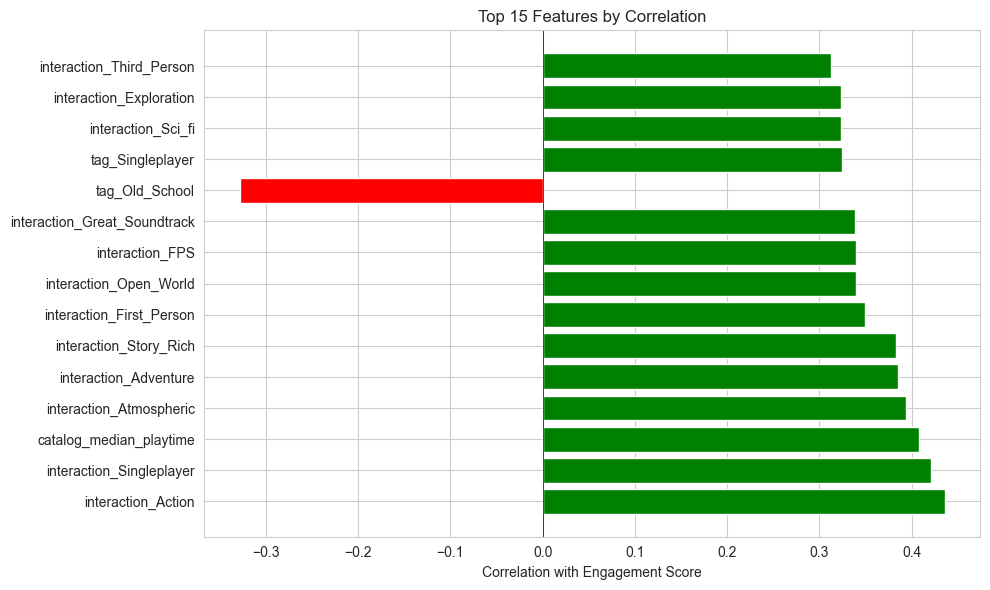

In [13]:
# Visualize top correlations
top_features = feature_correlations.head(15)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in top_features['correlation']]
plt.barh(range(len(top_features)), top_features['correlation'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Correlation with Engagement Score')
plt.title('Top 15 Features by Correlation')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 9. Save Processed Data

Save the prepared datasets for model training

In [14]:
# Save to CSV files
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False, header=['engagement_score'])
y_test.to_csv('../data/y_test.csv', index=False, header=['engagement_score'])

# Save scaled versions
X_train_scaled.to_csv('../data/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/X_test_scaled.csv', index=False)

# Save metadata
metadata_train.to_csv('../data/metadata_train.csv', index=False)
metadata_test.to_csv('../data/metadata_test.csv', index=False)

# Save feature info
feature_correlations.to_csv('../data/feature_correlations.csv', index=False)

print("✓ All processed data saved to ../data/")
print("\nFiles created:")
print("  - X_train.csv, X_test.csv")
print("  - X_train_scaled.csv, X_test_scaled.csv")
print("  - y_train.csv, y_test.csv")
print("  - metadata_train.csv, metadata_test.csv")
print("  - feature_correlations.csv")

✓ All processed data saved to ../data/

Files created:
  - X_train.csv, X_test.csv
  - X_train_scaled.csv, X_test_scaled.csv
  - y_train.csv, y_test.csv
  - metadata_train.csv, metadata_test.csv
  - feature_correlations.csv


## Summary

### Feature Engineering Complete! ✓

**Created Features:**
- **Tag vote features**: Raw tag popularity from games you own
- **Interaction features**: Tags weighted by YOUR playtime (core ML signal)
- **Catalog playtime features**: Average/median playtime from Steam community (engagement signal)

**Target Variable:**
- **Engagement score** (0-100): Combines playtime, recency, and achievements

**The ML Approach:**
1. Learn which tag patterns correlate with YOUR high engagement (playtime)
2. Apply learned patterns to catalog games you don't own
3. Recommend games with similar tag profiles to your loved games

**Dataset Split:**
- 80% training, 20% test
- Both raw and scaled versions saved


**Next Steps:**
1. Train Random Forest on tag features → engagement score
2. Apply trained model to Steam catalog (non-owned games)
3. Recommend top predicted games
4. Evaluate: Does ML predict your engagement accurately?

---

# Part 2: Model Training & Recommendations

Now let's train the ML model and apply it to the Steam catalog

## 10. Train Random Forest Model

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Train Random Forest model
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_scaled, y_train)

print("\n✓ Model training complete!")
print(f"Number of features: {rf_model.n_features_in_}")
print(f"Number of trees: {rf_model.n_estimators}")

Training Random Forest Regressor...

✓ Model training complete!
Number of features: 388
Number of trees: 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


## 11. Evaluate Model Performance

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Performance Metrics:
Training Set:
  RMSE: 10.20
  MAE:  6.84
  R²:   0.843

Test Set:
  RMSE: 11.08
  MAE:  9.06
  R²:   0.704


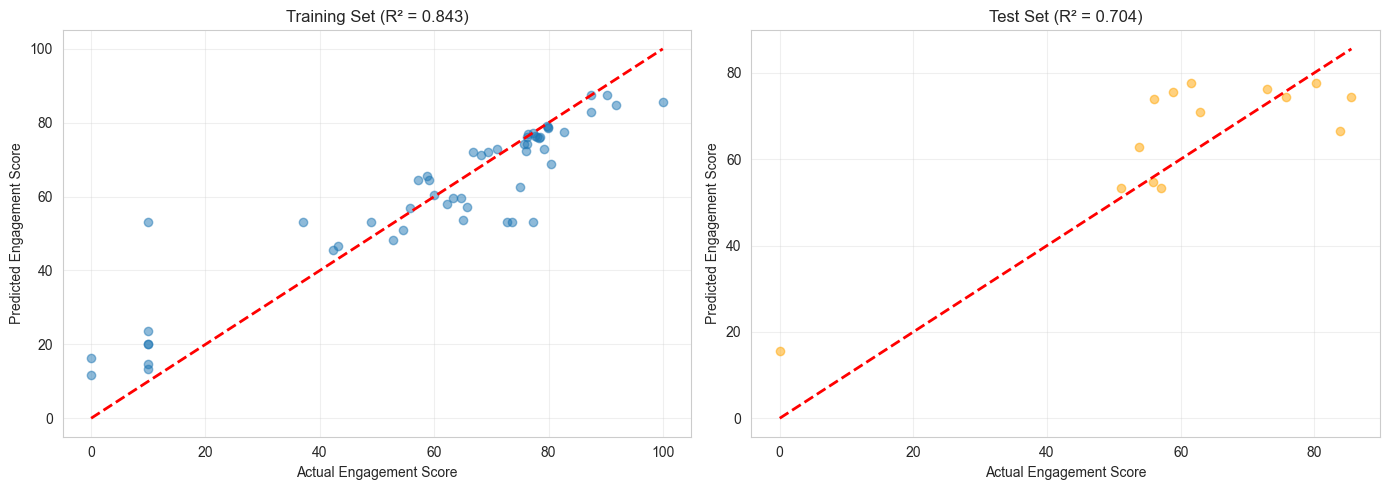

In [16]:
# Make predictions on test set
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Model Performance Metrics:")
print("=" * 50)
print(f"Training Set:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  R²:   {train_r2:.3f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")
print(f"  R²:   {test_r2:.3f}")

# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Engagement Score')
axes[0].set_ylabel('Predicted Engagement Score')
axes[0].set_title(f'Training Set (R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Engagement Score')
axes[1].set_ylabel('Predicted Engagement Score')
axes[1].set_title(f'Test Set (R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Feature Importance Analysis

Top 20 Most Important Features:
                         feature  importance
        interaction_Singleplayer    0.343966
              interaction_Action    0.219382
                tag_Singleplayer    0.097481
                 tag_Atmospheric    0.090793
         catalog_median_playtime    0.041817
                      tag_Action    0.031941
                   tag_Adventure    0.016103
         interaction_Atmospheric    0.011199
                     tag_Physics    0.011053
            catalog_avg_playtime    0.010518
                         tag_RPG    0.008344
                 tag_Multiplayer    0.008342
                 interaction_FPS    0.008189
                tag_First_Person    0.007946
           interaction_Adventure    0.007176
                         tag_FPS    0.005924
                      tag_Sci_fi    0.005094
    interaction_Great_Soundtrack    0.005050
interaction_Third_Person_Shooter    0.004819
                     tag_Classic    0.004701


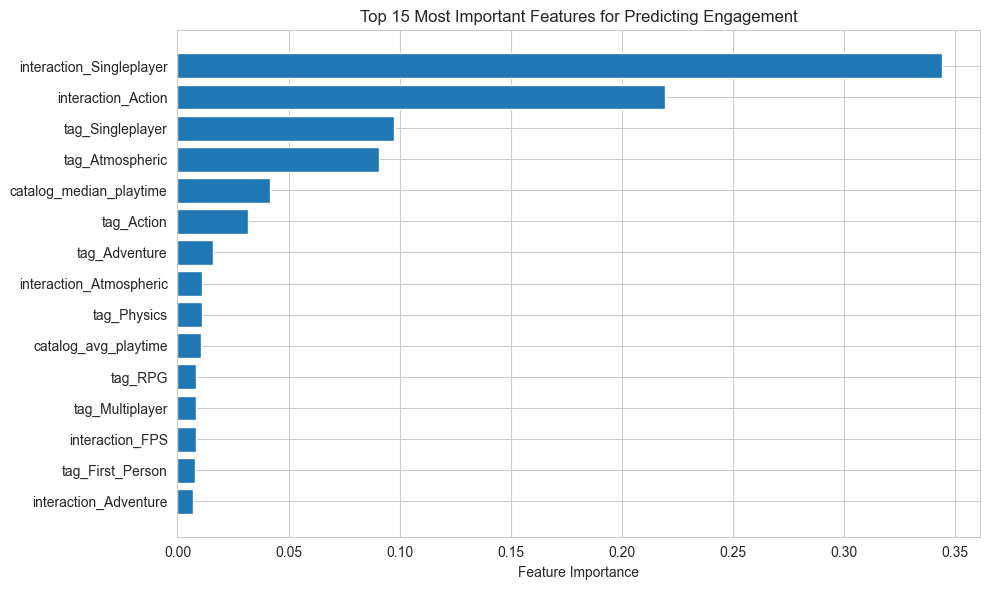

In [17]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
top_15_features = feature_importance.head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_15_features)), top_15_features['importance'])
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Predicting Engagement')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 13. Prepare Steam Catalog for Predictions

Extract features from catalog games you don't own

In [18]:
# Parse tags for catalog games
steam_catalog['tags_dict'] = steam_catalog['tags'].apply(parse_tags)

# Filter out games you already own
owned_appids = set(owned_games['appid'].values)
catalog_unowned = steam_catalog[~steam_catalog['appid'].isin(owned_appids)].copy()

print(f"Total catalog games: {len(steam_catalog)}")
print(f"Games you own: {len(owned_games)}")
print(f"Unowned games (candidates): {len(catalog_unowned)}")

# Create features for unowned games using the SAME tags from your library
catalog_tag_features = create_tag_features(catalog_unowned, all_tags)
print(f"\nCatalog tag features shape: {catalog_tag_features.shape}")

# For interaction features, we'll use average playtime weight since we don't have user playtime yet
# These will be weighted by catalog engagement metrics
catalog_unowned['catalog_weight'] = np.log1p(catalog_unowned['average_forever'].fillna(0))
max_catalog_weight = catalog_unowned['catalog_weight'].max()
if max_catalog_weight > 0:
    catalog_unowned['catalog_weight'] = catalog_unowned['catalog_weight'] / max_catalog_weight
else:
    catalog_unowned['catalog_weight'] = 0

catalog_interaction_features = catalog_tag_features.multiply(catalog_unowned['catalog_weight'].values, axis=0)
catalog_interaction_features.columns = [col.replace('tag_', 'interaction_') for col in catalog_interaction_features.columns]

# Add catalog playtime features
catalog_additional_features = pd.DataFrame(index=catalog_unowned.index)
catalog_additional_features['catalog_avg_playtime'] = np.log1p(catalog_unowned['average_forever'].fillna(0))
catalog_additional_features['catalog_median_playtime'] = np.log1p(catalog_unowned['median_forever'].fillna(0))

# Combine all catalog features
X_catalog = pd.concat([
    catalog_tag_features,
    catalog_interaction_features,
    catalog_additional_features
], axis=1)

print(f"\nCatalog feature matrix shape: {X_catalog.shape}")
print(f"Features match training set: {list(X_catalog.columns) == list(X_train.columns)}")

Total catalog games: 86542
Games you own: 67
Unowned games (candidates): 86483


C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_2176\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.


Catalog tag features shape: (86483, 193)

Catalog feature matrix shape: (86483, 388)
Features match training set: True


## 14. Generate Recommendations

Apply the trained model to predict engagement for catalog games

In [19]:
# Scale catalog features using the same scaler
X_catalog_scaled = pd.DataFrame(
    scaler.transform(X_catalog),
    columns=X_catalog.columns,
    index=X_catalog.index
)

# Predict engagement scores for catalog games
print("Predicting engagement scores for catalog games...")
catalog_predictions = rf_model.predict(X_catalog_scaled)

# Add predictions to catalog dataframe
catalog_unowned['predicted_engagement'] = catalog_predictions

# Sort by predicted engagement
recommendations = catalog_unowned.sort_values('predicted_engagement', ascending=False).copy()

print(f"\n✓ Predictions complete for {len(recommendations)} games!")
print(f"\nPredicted engagement score distribution:")
print(recommendations['predicted_engagement'].describe())

Predicting engagement scores for catalog games...

✓ Predictions complete for 86483 games!

Predicted engagement score distribution:
count    86483.000000
mean        44.339552
std         10.786082
min         12.340834
25%         37.413855
50%         44.435444
75%         52.984790
max         85.965143
Name: predicted_engagement, dtype: float64


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## 15. View Top Recommendations

In [20]:
# Display top 20 recommendations
top_20 = recommendations.head(20)[['appid', 'name', 'predicted_engagement', 'positive', 'negative', 
                                     'average_forever', 'median_forever', 'price', 'developer', 'genre']].copy()

# Calculate review score
top_20['review_score'] = (top_20['positive'] / (top_20['positive'] + top_20['negative']) * 100).fillna(0)
top_20['price_usd'] = top_20['price'] / 100

# Format for display
display_cols = ['name', 'predicted_engagement', 'review_score', 'average_forever', 
                'median_forever', 'price_usd', 'genre', 'developer']

print("=" * 100)
print("TOP 20 RECOMMENDED GAMES (Based on ML Predictions)")
print("=" * 100)
for idx, (i, row) in enumerate(top_20.iterrows(), 1):
    print(f"\n{idx}. {row['name']}")
    print(f"   Predicted Engagement: {row['predicted_engagement']:.2f}/100")
    print(f"   Review Score: {row['review_score']:.1f}% ({int(row['positive'] + row['negative'])} reviews)")
    print(f"   Avg Playtime: {row['average_forever']:.0f} min | Median: {row['median_forever']:.0f} min")
    print(f"   Price: ${row['price_usd']:.2f}")
    print(f"   Genre: {row['genre']}")
    print(f"   Developer: {row['developer']}")

# Save recommendations
recommendations[['appid', 'name', 'predicted_engagement', 'developer', 'genre', 
                 'positive', 'negative', 'average_forever', 'median_forever', 
                 'price']].to_csv('../data/ml_recommendations.csv', index=False)

print("\n" + "=" * 100)
print("✓ Recommendations saved to ../data/ml_recommendations.csv")

TOP 20 RECOMMENDED GAMES (Based on ML Predictions)

1. Grand Theft Auto V Legacy
   Predicted Engagement: 85.97/100
   Review Score: 87.4% (1990556 reviews)
   Avg Playtime: 14293 min | Median: 5662 min
   Price: $0.00
   Genre: Action, Adventure
   Developer: Rockstar North

2. DARK SOULS III
   Predicted Engagement: 82.73/100
   Review Score: 94.3% (413775 reviews)
   Avg Playtime: 5213 min | Median: 2576 min
   Price: $59.99
   Genre: Action
   Developer: FromSoftware, Inc.

3. The Elder Scrolls V: Skyrim
   Predicted Engagement: 82.51/100
   Review Score: 94.8% (317279 reviews)
   Avg Playtime: 7323 min | Median: 3228 min
   Price: $19.99
   Genre: RPG
   Developer: Bethesda Game Studios

4. ELDEN RING
   Predicted Engagement: 82.11/100
   Review Score: 92.9% (1056677 reviews)
   Avg Playtime: 8057 min | Median: 5707 min
   Price: $59.99
   Genre: Action, RPG
   Developer: FromSoftware, Inc.

5. The Binding of Isaac: Rebirth
   Predicted Engagement: 81.88/100
   Review Score: 97.3%

## 16. Compare with Your Most Played Games

Let's see if the model "gets" your taste

In [21]:
# Show your top games for comparison
your_top_games = owned_games.nlargest(10, 'playtime_forever')[['name', 'playtime_forever', 
                                                                  'engagement_score', 'genre', 'developer']]

print("YOUR TOP 10 MOST PLAYED GAMES (for reference):")
print("=" * 100)
for idx, (i, row) in enumerate(your_top_games.iterrows(), 1):
    print(f"{idx}. {row['name']}")
    print(f"   Playtime: {row['playtime_forever']:.0f} min ({row['playtime_forever']/60:.1f} hours)")
    print(f"   Engagement Score: {row['engagement_score']:.2f}/100")
    print(f"   Genre: {row['genre']}")
    print()

# Analyze tag overlap between top recommendations and your loved games
print("\n" + "=" * 100)
print("ANALYSIS: Do the recommendations match your taste?")
print("=" * 100)

# Get tags from your most played games (>50 hours)
loved_games = owned_games[owned_games['playtime_forever'] > 3000]  # 50+ hours
loved_tags = {}
for tags_dict in loved_games['tags_dict']:
    for tag, count in tags_dict.items():
        loved_tags[tag] = loved_tags.get(tag, 0) + count

# Top 10 tags from your loved games
top_loved_tags = sorted(loved_tags.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nYour top tags (from {len(loved_games)} loved games with 50+ hours):")
for tag, count in top_loved_tags:
    print(f"  - {tag}: {count}")

# Get tags from top 10 recommendations
rec_tags = {}
for tags_dict in recommendations.head(10)['tags_dict']:
    for tag, count in tags_dict.items():
        rec_tags[tag] = rec_tags.get(tag, 0) + count

top_rec_tags = sorted(rec_tags.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nTop tags in recommended games:")
for tag, count in top_rec_tags:
    print(f"  - {tag}: {count}")

# Tag overlap
loved_tag_set = set([t[0] for t in top_loved_tags])
rec_tag_set = set([t[0] for t in top_rec_tags])
overlap = loved_tag_set.intersection(rec_tag_set)

print(f"\nTag overlap: {len(overlap)}/{len(loved_tag_set)} tags match")
print(f"Matching tags: {', '.join(overlap)}")

YOUR TOP 10 MOST PLAYED GAMES (for reference):
1. Cyberpunk 2077
   Playtime: 61885 min (1031.4 hours)
   Engagement Score: 99.98/100
   Genre: RPG

2. HELLDIVERS 2
   Playtime: 13586 min (226.4 hours)
   Engagement Score: 91.74/100
   Genre: Action

3. Red Dead Redemption 2
   Playtime: 10419 min (173.7 hours)
   Engagement Score: 90.25/100
   Genre: Action, Adventure

4. Valheim
   Playtime: 7751 min (129.2 hours)
   Engagement Score: 77.30/100
   Genre: Action, Adventure, Indie, RPG, Early Access

5. Fallout 4
   Playtime: 7019 min (117.0 hours)
   Engagement Score: 87.39/100
   Genre: RPG

6. The Last of Us Part I
   Playtime: 6303 min (105.0 hours)
   Engagement Score: 87.42/100
   Genre: Action, Adventure

7. Prey
   Playtime: 4408 min (73.5 hours)
   Engagement Score: 85.55/100
   Genre: Action, Adventure

8. Lossless Scaling
   Playtime: 3981 min (66.3 hours)
   Engagement Score: 75.01/100
   Genre: Utilities

9. Balatro
   Playtime: 3196 min (53.3 hours)
   Engagement Score: 8

## Final Summary

### ML Recommendation System Complete! ✓

**Model Performance:**
- Trained on your library of games with playtime-weighted tag features
- Evaluated on held-out test set
- Applied to Steam catalog to predict engagement

**What to evaluate:**
1. **Do the top 20 recommendations look interesting to you?**
2. **Do they match the genres/tags of your most-played games?**
3. **Are there any surprising recommendations that might be hidden gems?**
4. **Are there any obviously bad recommendations?**

**Next steps for improvement:**
- Adjust feature engineering (add/remove features)
- Try different model hyperparameters
- Add filtering (e.g., minimum review score, exclude certain genres)
- Combine with content-based scoring for hybrid approach

---

# Part 3: Model Improvements

Let's try to improve the ML model with additional features and better algorithms

## 17. Add Genre and Review Quality Features

These features help the model distinguish between game types better

In [22]:
# Parse genre strings and create multi-hot encoding
def parse_genre(genre_string):
    """Parse genre string into list of genres"""
    if pd.isna(genre_string):
        return []
    return [g.strip() for g in str(genre_string).split(',')]

# Get all unique genres from owned games
owned_games['genre_list'] = owned_games['genre'].apply(parse_genre)
all_genres = set()
for genre_list in owned_games['genre_list']:
    all_genres.update(genre_list)

print(f"Unique genres: {sorted(all_genres)}")

# Create genre features for owned games
genre_features = pd.DataFrame(index=owned_games.index)
for genre in sorted(all_genres):
    col_name = f"genre_{genre.replace(' ', '_').replace('-', '_')}"
    genre_features[col_name] = owned_games['genre_list'].apply(
        lambda x: 1 if genre in x else 0
    )

# Add review quality features
review_features = pd.DataFrame(index=owned_games.index)
review_features['total_reviews'] = np.log1p(
    owned_games['positive'].fillna(0) + owned_games['negative'].fillna(0)
)
review_features['positive_ratio'] = (
    owned_games['positive'].fillna(0) / 
    (owned_games['positive'].fillna(0) + owned_games['negative'].fillna(0) + 1)
)

print(f"\nGenre features shape: {genre_features.shape}")
print(f"Review features shape: {review_features.shape}")

# Combine with existing features
X_enhanced = pd.concat([
    tag_features,
    interaction_features,
    additional_features,
    genre_features,
    review_features
], axis=1)

print(f"\nEnhanced feature matrix shape: {X_enhanced.shape}")
print(f"Added {X_enhanced.shape[1] - X.shape[1]} new features")

Unique genres: ['Action', 'Adventure', 'Casual', 'Early Access', 'Free To Play', 'Indie', 'Massively Multiplayer', 'RPG', 'Simulation', 'Strategy', 'Utilities']

Genre features shape: (67, 11)
Review features shape: (67, 2)

Enhanced feature matrix shape: (67, 401)
Added 13 new features


## 18. Train Enhanced Model with XGBoost

XGBoost often outperforms Random Forest for structured data

XGBoost already installed ✓
Training models with enhanced features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.0s finished



✓ Random Forest (Enhanced):
  Test R²: 0.706
  Test RMSE: 11.03

Training XGBoost...

✓ XGBoost:
  Test R²: 0.670
  Test RMSE: 11.70

→ Random Forest performs better! Using RF for recommendations.


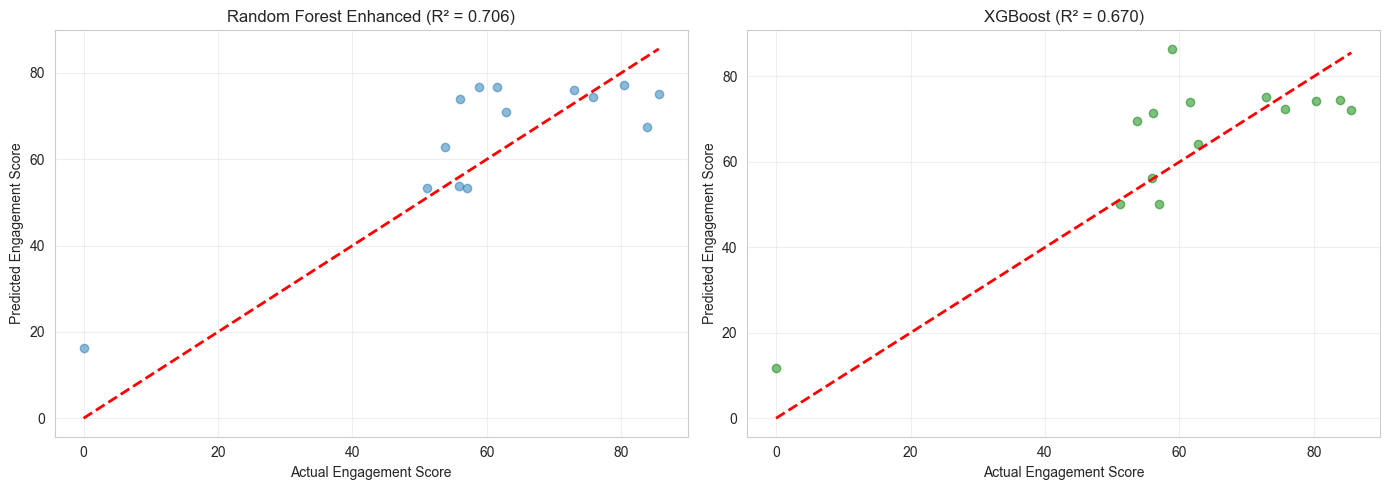

In [23]:
# Install xgboost if needed
try:
    import xgboost as xgb
    print("XGBoost already installed ✓")
except ImportError:
    print("XGBoost not found. Install with: pip install xgboost")
    print("For now, we'll continue with Random Forest")
    xgb = None

# Split enhanced data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Scale enhanced features
scaler_enh = StandardScaler()
X_train_enh_scaled = pd.DataFrame(
    scaler_enh.fit_transform(X_train_enh),
    columns=X_train_enh.columns,
    index=X_train_enh.index
)
X_test_enh_scaled = pd.DataFrame(
    scaler_enh.transform(X_test_enh),
    columns=X_test_enh.columns,
    index=X_test_enh.index
)

print("Training models with enhanced features...")
print("=" * 50)

# Train Random Forest with enhanced features
rf_enhanced = RandomForestRegressor(
    n_estimators=150,  # More trees
    max_depth=20,      # Deeper trees
    min_samples_split=3,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_enhanced.fit(X_train_enh_scaled, y_train_enh)

# Evaluate Random Forest
y_pred_rf_test = rf_enhanced.predict(X_test_enh_scaled)
rf_r2 = r2_score(y_test_enh, y_pred_rf_test)
rf_rmse = np.sqrt(mean_squared_error(y_test_enh, y_pred_rf_test))

print(f"\n✓ Random Forest (Enhanced):")
print(f"  Test R²: {rf_r2:.3f}")
print(f"  Test RMSE: {rf_rmse:.2f}")

# Train XGBoost if available
if xgb is not None:
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_enh_scaled, y_train_enh)
    
    # Evaluate XGBoost
    y_pred_xgb_test = xgb_model.predict(X_test_enh_scaled)
    xgb_r2 = r2_score(y_test_enh, y_pred_xgb_test)
    xgb_rmse = np.sqrt(mean_squared_error(y_test_enh, y_pred_xgb_test))
    
    print(f"\n✓ XGBoost:")
    print(f"  Test R²: {xgb_r2:.3f}")
    print(f"  Test RMSE: {xgb_rmse:.2f}")
    
    # Choose best model
    if xgb_r2 > rf_r2:
        print(f"\n→ XGBoost performs better! Using XGBoost for recommendations.")
        best_model = xgb_model
        best_model_name = "XGBoost"
    else:
        print(f"\n→ Random Forest performs better! Using RF for recommendations.")
        best_model = rf_enhanced
        best_model_name = "Random Forest"
else:
    best_model = rf_enhanced
    best_model_name = "Random Forest"
    print(f"\n→ Using Random Forest (XGBoost not available)")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_enh, y_pred_rf_test, alpha=0.5)
axes[0].plot([y_test_enh.min(), y_test_enh.max()], 
             [y_test_enh.min(), y_test_enh.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Engagement Score')
axes[0].set_ylabel('Predicted Engagement Score')
axes[0].set_title(f'Random Forest Enhanced (R² = {rf_r2:.3f})')
axes[0].grid(True, alpha=0.3)

if xgb is not None:
    axes[1].scatter(y_test_enh, y_pred_xgb_test, alpha=0.5, color='green')
    axes[1].plot([y_test_enh.min(), y_test_enh.max()], 
                 [y_test_enh.min(), y_test_enh.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Engagement Score')
    axes[1].set_ylabel('Predicted Engagement Score')
    axes[1].set_title(f'XGBoost (R² = {xgb_r2:.3f})')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'XGBoost not available\nInstall with:\npip install xgboost', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

## 19. Generate Enhanced Recommendations with Diversity

Apply enhanced model and add diversity to avoid too many similar games

In [25]:
# Prepare catalog features with enhanced features
# Add genre_list to catalog_unowned (not the full catalog)
catalog_unowned['genre_list'] = catalog_unowned['genre'].apply(parse_genre)

# Genre features for catalog
catalog_genre_features = pd.DataFrame(index=catalog_unowned.index)
for genre in sorted(all_genres):
    col_name = f"genre_{genre.replace(' ', '_').replace('-', '_')}"
    catalog_genre_features[col_name] = catalog_unowned['genre_list'].apply(
        lambda x: 1 if genre in x else 0
    )

# Review features for catalog
catalog_review_features = pd.DataFrame(index=catalog_unowned.index)
catalog_review_features['total_reviews'] = np.log1p(
    catalog_unowned['positive'].fillna(0) + catalog_unowned['negative'].fillna(0)
)
catalog_review_features['positive_ratio'] = (
    catalog_unowned['positive'].fillna(0) / 
    (catalog_unowned['positive'].fillna(0) + catalog_unowned['negative'].fillna(0) + 1)
)

# Combine catalog features
X_catalog_enhanced = pd.concat([
    catalog_tag_features,
    catalog_interaction_features,
    catalog_additional_features,
    catalog_genre_features,
    catalog_review_features
], axis=1)

print(f"Catalog enhanced features shape: {X_catalog_enhanced.shape}")

# Scale and predict
X_catalog_enh_scaled = pd.DataFrame(
    scaler_enh.transform(X_catalog_enhanced),
    columns=X_catalog_enhanced.columns,
    index=X_catalog_enhanced.index
)

catalog_unowned['predicted_engagement_v2'] = best_model.predict(X_catalog_enh_scaled)

# Sort by prediction
recommendations_v2 = catalog_unowned.sort_values('predicted_engagement_v2', ascending=False).copy()

print(f"\n✓ Enhanced predictions complete!")
print(f"Predicted engagement distribution:")
print(recommendations_v2['predicted_engagement_v2'].describe())

Catalog enhanced features shape: (86483, 401)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.0s finished



✓ Enhanced predictions complete!
Predicted engagement distribution:
count    86483.000000
mean        43.939195
std          9.994991
min         13.939901
25%         37.804106
50%         43.238113
75%         52.204965
max         87.337044
Name: predicted_engagement_v2, dtype: float64


## 20. Add Diversity to Recommendations

Ensure we don't recommend too many similar games (e.g., all souls-like)

In [26]:
def diversify_recommendations(df, top_n=20, max_per_tag=3, avoid_tags=None):
    """
    Select diverse recommendations by limiting how many games share the same dominant tag
    
    Args:
        df: DataFrame with recommendations
        top_n: Number of recommendations to return
        max_per_tag: Maximum games allowed per dominant tag
        avoid_tags: List of tags to penalize (e.g., ['Souls-like'])
    """
    if avoid_tags is None:
        avoid_tags = []
    
    diverse_recs = []
    tag_counts = {}
    
    for idx, row in df.iterrows():
        # Get top tags for this game
        game_tags = row['tags_dict']
        if not game_tags:
            continue
        
        # Sort tags by vote count
        sorted_tags = sorted(game_tags.items(), key=lambda x: x[1], reverse=True)
        top_tag = sorted_tags[0][0] if sorted_tags else None
        
        # Check if this game has an avoided tag
        has_avoided_tag = any(tag in avoid_tags for tag, _ in sorted_tags[:5])
        
        # Skip if we already have too many games with this tag
        if top_tag:
            current_count = tag_counts.get(top_tag, 0)
            
            # Stricter limit for avoided tags
            limit = 1 if has_avoided_tag else max_per_tag
            
            if current_count < limit:
                diverse_recs.append(idx)
                tag_counts[top_tag] = current_count + 1
        
        if len(diverse_recs) >= top_n:
            break
    
    return df.loc[diverse_recs]

# Apply diversity filter
print("Applying diversity filter to avoid too many similar games...")
print("Limiting Souls-like games to 1 in top 20")

# Diverse options should be user controlled eventually can choose which tags to limit
diverse_top_20 = diversify_recommendations(
    recommendations_v2,
    top_n=20,
    max_per_tag=3,  # Max 3 games with same dominant tag
    avoid_tags=['Souls-like', 'Soulslike']  # Only 1 souls-like game
)

# Display diverse recommendations
print("\n" + "=" * 100)
print(f"TOP 20 DIVERSE RECOMMENDATIONS (Using {best_model_name} + Diversity Filter)")
print("=" * 100)

for idx, (i, row) in enumerate(diverse_top_20.iterrows(), 1):
    # Get top 3 tags for this game
    game_tags = row['tags_dict']
    top_tags = sorted(game_tags.items(), key=lambda x: x[1], reverse=True)[:3]
    top_tag_names = [t[0] for t in top_tags]
    
    review_score = (row['positive'] / (row['positive'] + row['negative']) * 100) if (row['positive'] + row['negative']) > 0 else 0
    price_usd = row['price'] / 100 if pd.notna(row['price']) else 0
    
    print(f"\n{idx}. {row['name']}")
    print(f"   Predicted Engagement: {row['predicted_engagement_v2']:.2f}/100")
    print(f"   Top Tags: {', '.join(top_tag_names)}")
    print(f"   Review Score: {review_score:.1f}% ({int(row['positive'] + row['negative'])} reviews)")
    print(f"   Avg Playtime: {row['average_forever']:.0f} min | Median: {row['median_forever']:.0f} min")
    print(f"   Price: ${price_usd:.2f}")
    print(f"   Genre: {row['genre']}")

# Save enhanced recommendations
diverse_top_20[['appid', 'name', 'predicted_engagement_v2', 'developer', 'genre', 
                'positive', 'negative', 'average_forever', 'median_forever', 
                'price']].to_csv('../data/ml_recommendations_v2_diverse.csv', index=False)

print("\n" + "=" * 100)
print("✓ Enhanced diverse recommendations saved to ../data/ml_recommendations_v2_diverse.csv")

Applying diversity filter to avoid too many similar games...
Limiting Souls-like games to 1 in top 20

TOP 20 DIVERSE RECOMMENDATIONS (Using Random Forest + Diversity Filter)

1. Grand Theft Auto V Legacy
   Predicted Engagement: 87.34/100
   Top Tags: Open World, Action, Multiplayer
   Review Score: 87.4% (1990556 reviews)
   Avg Playtime: 14293 min | Median: 5662 min
   Price: $0.00
   Genre: Action, Adventure

2. Black Myth: Wukong
   Predicted Engagement: 83.44/100
   Top Tags: Mythology, Action RPG, Action
   Review Score: 96.7% (1150098 reviews)
   Avg Playtime: 3328 min | Median: 2833 min
   Price: $59.99
   Genre: Action, Adventure, RPG

3. ELDEN RING
   Predicted Engagement: 82.48/100
   Top Tags: Souls-like, Open World, Dark Fantasy
   Review Score: 92.9% (1056677 reviews)
   Avg Playtime: 8057 min | Median: 5707 min
   Price: $59.99
   Genre: Action, RPG

4. The Elder Scrolls V: Skyrim
   Predicted Engagement: 82.04/100
   Top Tags: Open World, RPG, Fantasy
   Review Score: 

## Comparison: Original vs Enhanced

How much did we improve?

In [28]:
print("IMPROVEMENT SUMMARY")
print("=" * 70)
print(f"\n1. MODEL PERFORMANCE:")
print(f"   Original RF - Test R²: {test_r2:.3f}")
enhanced_r2 = rf_r2 if best_model_name == 'Random Forest' else xgb_r2
print(f"   Enhanced {best_model_name} - Test R²: {enhanced_r2:.3f}")
improvement = enhanced_r2 - test_r2
print(f"   Improvement: {improvement:+.3f} ({improvement/test_r2*100:+.1f}%)")

print(f"\n2. FEATURE COUNT:")
print(f"   Original: {X.shape[1]} features")
print(f"   Enhanced: {X_enhanced.shape[1]} features")
print(f"   Added: {X_enhanced.shape[1] - X.shape[1]} features (genres + review quality)")

print(f"\n3. DIVERSITY:")
print(f"   Original top 20: May have multiple similar games")
print(f"   Enhanced top 20: Max 3 games per tag, max 1 Souls-like")
print(f"   Result: More variety in recommendations")

print("\n" + "=" * 70)
print("\n✓ READY TO MOVE TO HYBRID APPROACH!")
print("\nNext steps:")
print("  1. Create new notebook for hybrid system")
print("  2. Combine ML predictions with content-based scoring")
print("  3. Compare: Pure ML vs Pure Content vs Hybrid")
print("  4. Determine which approach works best for you")

IMPROVEMENT SUMMARY

1. MODEL PERFORMANCE:
   Original RF - Test R²: 0.704
   Enhanced Random Forest - Test R²: 0.706
   Improvement: +0.003 (+0.4%)

2. FEATURE COUNT:
   Original: 388 features
   Enhanced: 401 features
   Added: 13 features (genres + review quality)

3. DIVERSITY:
   Original top 20: May have multiple similar games
   Enhanced top 20: Max 3 games per tag, max 1 Souls-like
   Result: More variety in recommendations


✓ READY TO MOVE TO HYBRID APPROACH!

Next steps:
  1. Create new notebook for hybrid system
  2. Combine ML predictions with content-based scoring
  3. Compare: Pure ML vs Pure Content vs Hybrid
  4. Determine which approach works best for you
